# NewRad2023

In [1]:
import numpy as np
import luxpy as lx
from luxpy import _CIE_ILLUMINANTS, SPD, _CMF
from empir19nrm02 import _SPD, _RES

from empir19nrm02.tools.help import strd, label_font_size, plot_cmf2, save_fig, get_target, label_management, \
    quantil, display_responsivity
from empir19nrm02.MC import load_from_csv, load_from_excel, MCVar, MCVectorVar, NameUnit, DistributionParam, MCSimulation,noise_list_default
from empir19nrm02.spectral.spectral_data import _CORR_PATH
from empir19nrm02.tools import plotHistScales, plotHistGauss, plot_2D, get_data_step, seaborn_plot_result_gen, plotCorrelation
from matplotlib import pyplot
from empir19nrm02.MC import StatDataVector

## Some settings for the processing

In [2]:
# Calibration illuminant
S_C = 'A'
#S_C = 'L41'
print( 'Calibration with: ', S_C)

# Select the color space for evaluation
cieobs = '1931_2'
print('Color matching functions from:', cieobs)

# display the colorbar in some diagrams
spectrum_color = False

# outdir
out_dir = 'NewRad2023'

Calibration with:  A
Color matching functions from: 1931_2


## The Detector for the NewRad article is included in the general list with #128
### Load here without any uncertainty information

VLDetectors


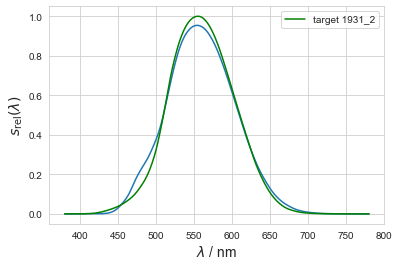

f1prime=7.3 %


In [3]:
_detectors=_RES['VLDetectors']['S']['data'].copy()
# the detector from Yasaman (eMail: 230317)
det_number = 128
detector_tmp = np.vstack((_detectors[0], _detectors[det_number]))

# wavelength scale for further use
wl = lx.getwlr((380,780,1))

# MCS
trials = 2000

detector = lx.cie_interp(detector_tmp, wl, kind='S')
detector_norm, f1p = display_responsivity('VLDetectors', detector, cieobs=cieobs, s_target_index=2, out_dir=out_dir, S_C=S_C, spectrum_color=spectrum_color, plots=['plot1'])
print( f'f1prime={f1p[0]*100:0.2} %')

## A more general way to caculate SMCF
# $F(S_\mathrm{Z}(\lambda),S_\mathrm{C}(\lambda) = \frac{F_\mathrm{C,N}}{F_\mathrm{C,D}}\frac{F_\mathrm{M,N}}{F_\mathrm{M,D}}$

# $F_\mathrm{C,N} = \int{S_\mathrm{C}(\lambda)s(\lambda)\mathrm{d}\lambda}$
# $F_\mathrm{C,D} = \int{S_\mathrm{C}(\lambda)s_\mathrm{T}(\lambda)\mathrm{d}\lambda}$
# $F_\mathrm{M,N} = \int{S_\mathrm{Z}(\lambda)s_\mathrm{T}(\lambda)\mathrm{d}\lambda}$
# $F_\mathrm{M,D} = \int{S_\mathrm{Z}(\lambda)s(\lambda)\mathrm{d}\lambda}$

# $F(S_\mathrm{Z}(\lambda),S_\mathrm{C}(\lambda) = \underbrace{\frac{\int{S_\mathrm{C}(\lambda)s(\lambda)\mathrm{d}\lambda}}{\int{S_\mathrm{C}(\lambda)s_\mathrm{T}(\lambda)\mathrm{d}\lambda}}}_{\text{Calibration}}\underbrace{\frac{\int{S_\mathrm{Z}(\lambda)s_\mathrm{T}(\lambda)\mathrm{d}\lambda}}{\int{S_\mathrm{Z}(\lambda)s(\lambda)\mathrm{d}\lambda}}}_{\text{Measurement}}$

| Symbol | Description |
| :-:    |  :-:   |
| $F(S_\mathrm{Z}(\lambda)$ | SD DUT |
| $F(S_\mathrm{C}(\lambda)$ | SD Calibration |
| $s(\lambda)$ | (rel.) spectral responsivity of detetor |
| $s_\mathrm{T}(\lambda)$ |  spectral responsivity of the target function (e.g. $V(\lambda)$ |


In [4]:
g_S_C_ref = None
g_S_Z_ref = None
g_s_detector_ref = None

def smcf_set_ref( _S_C_ref, _S_Z_ref, _s_detector_ref):
    global g_S_C_ref, g_S_Z_ref, g_s_detector_ref

    if isinstance(_S_C_ref,str):
        g_S_C_ref = _CIE_ILLUMINANTS[_S_C_ref].copy()
    else:
        if isinstance(_S_C_ref, SPD):
            g_S_C_ref = np.vstack( (_S_C_ref.wl, _S_C_ref.value))
        else:
            g_S_C_ref = _S_C_ref.copy()

    if isinstance(_S_Z_ref,str):
        g_S_Z_ref = _CIE_ILLUMINANTS[_S_Z_ref].copy()
    else:
        if isinstance(_S_Z_ref, SPD):
            g_S_Z_ref = np.vstack( (_S_Z_ref.wl, _S_Z_ref.value))
        else:
            g_S_Z_ref = _S_Z_ref.copy()
    if isinstance(_S_Z_ref, SPD):
        g_s_detector_ref = np.vstack( (_s_detector_ref.wl, _s_detector_ref.value))
    else:
        g_s_detector_ref = _s_detector_ref.copy()
    return

def smcf_calculation( S_Z, s_detector, S_C='A', cieobs='1931_2', s_target_index=2, interp_kind = 'S', use_ref = False, use_global_ref = False):

    # Get illuminant:
    if isinstance(S_C,str): S_C = _CIE_ILLUMINANTS[S_C].copy()

    s_target = _CMF[cieobs]['bar'][[0,s_target_index]].copy() if isinstance(cieobs, str) else cieobs[[0,s_target_index]].copy()

    wlr = s_detector[0] # get wavelength range from the detector data
    dl = lx.getwld(wlr) # wavelength differences (unequal wavelength spacings are taken into account)
    dl = dl*np.ones_like(wlr) # ensure array like for matrix multiplication

    # Interpolate measured spectrum to desired wavelength range:
    s_target = lx.cie_interp(s_target, wlr, kind = interp_kind)[1:]
    S_C = lx.cie_interp(S_C, wlr, kind = interp_kind)[1:]
    S_Z = lx.cie_interp(S_Z, wlr, kind = interp_kind)[1:]
    s_detector = s_detector[1:]

    # taking the first information as reference
    if use_ref:
        if use_global_ref:
            S_C_ref = lx.cie_interp(g_S_C_ref, wlr, kind = interp_kind)[1:]
            S_Z_ref = lx.cie_interp(g_S_Z_ref, wlr, kind = interp_kind)[1:]
            s_detector_ref = lx.cie_interp(g_s_detector_ref, wlr, kind = interp_kind)[1:]
            S_C_ref = np.tile(S_C_ref[0],(S_C.shape[0],1))
            S_Z_ref = np.tile(S_Z_ref[0],(S_Z.shape[0],1))
            s_detector_ref = np.tile(s_detector_ref[0],(s_detector.shape[0],1))
        else:
            S_C_ref = np.tile(S_C[0],(S_C.shape[0],1))
            S_Z_ref = np.tile(S_Z[0],(S_Z.shape[0],1))
            s_detector_ref = np.tile(s_detector[0],(s_detector.shape[0],1))
    else:
        S_C_ref = S_C
        S_Z_ref = S_Z
        s_detector_ref = s_detector

    use_luxpy = False
    F_M_N = 1
    F_M_D = 1
    F_C_N = 1
    F_C_D = 1
    if use_luxpy:
        # Calculate s_rel:
        s_rel = (s_target @ (S_C_ref*dl).T) / (s_detector_ref @ (S_C*dl).T) * s_detector
        # Calculate spectral mismatch correction factors:
        F = (S_Z_ref @ (s_target*dl).T) / (S_Z @ (s_rel*dl).T)
    else:
        # Calculate spectral mismatch correction factors:
        F_M_N = (S_Z_ref @ (s_target*dl).T)
        F_M_D = (S_Z @ (s_detector*dl).T)
        F_C_N = (S_C @ (s_detector_ref*dl).T)
        F_C_D = (S_C_ref @ (s_target*dl).T)
        F = F_C_N/F_C_D * F_M_N/F_M_D

    return F, F_C_N, F_C_D, F_M_N, F_M_D

In [5]:
def plotMCResult( wl, mcVarData:StatDataVector, title=None, fig = None, ax1 = None, ax2 = None, diagnumber=0):
    bFirst = False
    if not fig:
        fig, ax1 = pyplot.subplots()
        ax2 = ax1.twinx()
        color1 = 'r-'
        color2 = 'g-'
    else:
        if diagnumber == 1:
            color1 = 'r--'
            color2 = 'g--'
        else:
            color1 = 'r-.'
            color2 = 'g-.'

    if not title:
        title = ''
    ax1.plot(wl, mcVarData.v_mean/np.max(mcVarData.v_mean), color1, label= title + ' $s_{\mathrm{rel}}(\lambda)$')
    ax2.plot(wl,mcVarData.v_std / mcVarData.v_mean, color2, label= title + ' $u_{\mathrm{rel}}(s_{\mathrm{rel}})(\lambda)$')
    ax1.set_xlabel(strd['xlambda'])
    ax1.set_ylabel('Signal / A.U', color = 'red')
    ax2.set_ylabel('$\sigma_{\mathrm{rel}}$', color = 'green')
    if title:
        ax1.set_title(title)
    fig.legend()
    return fig, ax1, ax2

# Use FEL Lamp-1 from the PTB set

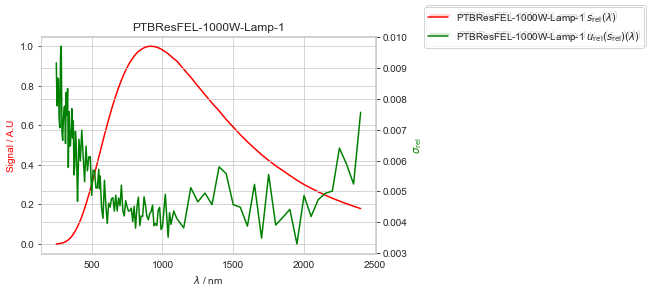

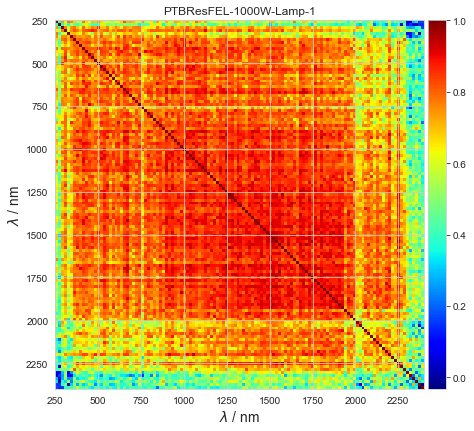

In [6]:
str_FEL_file = 'PTBResFEL-1000W-Lamp-1'
wlFEL, mcVectorVarFEL = load_from_csv(_CORR_PATH + '/' + str_FEL_file)
mcVectorVarFEL.name = NameUnit( str_FEL_file, 'A.U.')

fig, ax1, ax2 = plotMCResult(wlFEL, mcVectorVarFEL.setData, str_FEL_file)
fig.legend(bbox_to_anchor=(1,1), loc="upper left")
plotCorrelation(mcVectorVarFEL.setData.corr_matrix, wlFEL, str_FEL_file)

## Interpolate the lamp data to the wl scale of the simulation

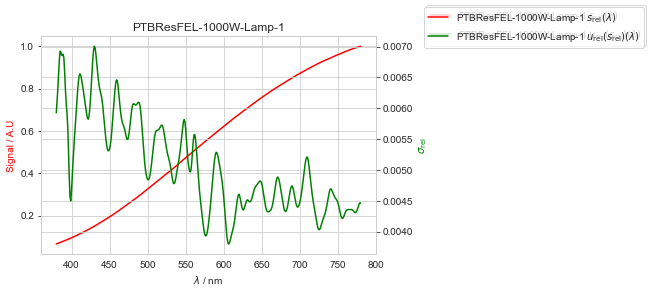

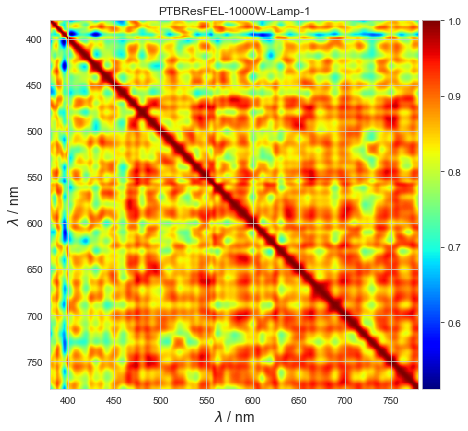

In [7]:
# put the data at the same WL-Scale
if len(wl) != mcVectorVarFEL.elements:
    mcVectorVarFEL.interpolate(wl, wlFEL, trials=trials)

fig, ax1, ax2 = plotMCResult(wl, mcVectorVarFEL.setData, str_FEL_file)
fig.legend(bbox_to_anchor=(1,1), loc="upper left")
save_fig(out_dir, 'FEL_SDi')

plotCorrelation(mcVectorVarFEL.setData.corr_matrix, wl, str_FEL_file)
save_fig(out_dir, 'FEL_Corri')

_spectra = np.vstack((wl, mcVectorVarFEL.setData.v_mean))

## Use Photometer information from PTB Data (only the uncertainty, the spectral responsivity is taken from #128)

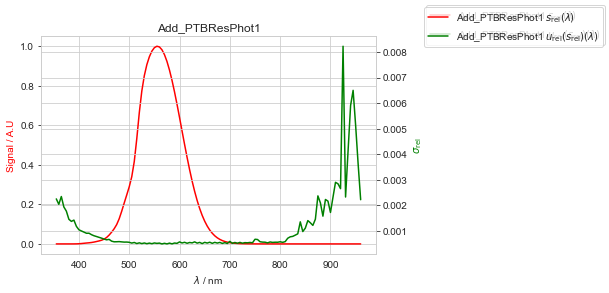

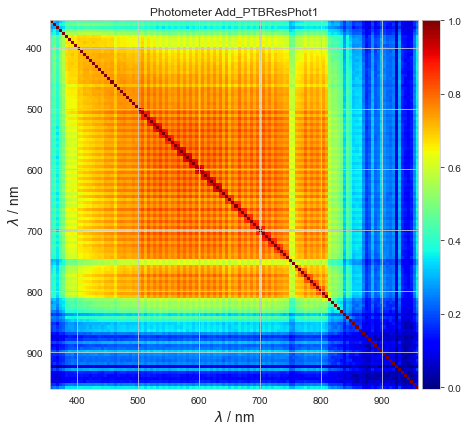

In [8]:
str_Phot_file = 'Add_PTBResPhot1'
wlPhot, mcVarDetector = load_from_excel(filename = _CORR_PATH + '/' + str_Phot_file, wlColumn = 1, valColumn=2, stdColumn = 3, covColumn=None, corrColumn = 4, startRow=2)
mcVarDetector.name = NameUnit( str_Phot_file, 'A.U.')

fig, ax1, ax2 = plotMCResult(wlPhot, mcVarDetector.setData, title=str_Phot_file)
fig.legend(bbox_to_anchor=(1,1), loc="upper left")

plotCorrelation(mcVarDetector.setData.corr_matrix, wlPhot, 'Photometer ' + str_Phot_file)

## Interpolate the photometer data to the wl scale of the simulation

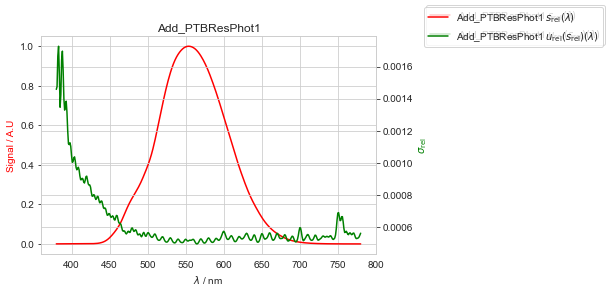

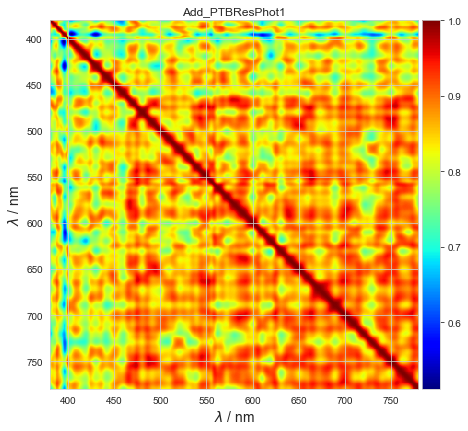

In [9]:
# put the data at the same WL-Scale
if len(wl) != mcVarDetector.elements:
    mcVarDetector.interpolate(wl, wlPhot, trials=trials)

# hold the relative standard deviation constant
v_std_rel = mcVarDetector.setData.v_std/mcVarDetector.setData.v_mean

# Use the mean value from detector #128 (hold the uncertainty data from the PTB measurements)
mcVarDetector.set_vector_param( detector[1], v_std=v_std_rel*detector[1], corr=mcVarDetector.setData.corr_matrix)

fig, ax1, ax2 = plotMCResult(wl, mcVarDetector.setData, str_Phot_file)
fig.legend(bbox_to_anchor=(1,1), loc="upper left")
save_fig(out_dir, 'Phot_SDi')

plotCorrelation(mcVectorVarFEL.setData.corr_matrix, wl, str_Phot_file)
save_fig(out_dir, 'Phot_Corri')

_detector = np.vstack((wl, mcVarDetector.setData.v_mean))


## Generate some uncertainty information for the calibration light source

In [10]:
from empir19nrm02.tools import draw_values_gum, sumMC

index_555nm = np.argmin(np.abs(wl-555))

calibrationMC = MCVectorVar(name=NameUnit('uncertain A', 'A.U.'), elements=len(wl))

# normalized to the value at 555nm
stdIllA = lx.cie_interp(_CIE_ILLUMINANTS['A'], wl, kind = 'S')[1:]
stdIllA[0] /= stdIllA[0][index_555nm]
print( stdIllA[0].shape)

# normalized to the maximum value
refSourceL41 = lx.cie_interp(_CIE_ILLUMINANTS['L41'], wl, kind = 'S')[1:]
refSourceL41 /= np.max(refSourceL41)

# random uncertainty 1%
calibrationMC.set_vector_param(stdIllA[0], v_std=np.ones(len(wl))*0.01)
calibrationMC.generate_numbers(trials=trials)

# BB's with an uncertain temperature and different normalization strategies
calibrationMCT = MCVectorVar(name=NameUnit('uncertain A T', 'A.U.'), elements=len(wl))
calibrationMCT.set_vector_param(stdIllA[0], v_std=np.ones(len(wl))*0.01)
calibrationMCT.allocate(trials)

calibrationMCT1 = MCVectorVar(name=NameUnit('uncertain A T1', 'A.U.'), elements=len(wl))
calibrationMCT1.set_vector_param(stdIllA[0], v_std=np.ones(len(wl))*0.01)
calibrationMCT1.allocate(trials)


calibrationMCT2 = MCVectorVar(name=NameUnit('uncertain A T2', 'A.U.'), elements=len(wl))
calibrationMCT2.set_vector_param(stdIllA[0], v_std=np.ones(len(wl))*0.01)
calibrationMCT2.allocate(trials)

#generate the MC data in front f the MCS
temp = draw_values_gum(mean=2856., stddev=10, draws=calibrationMCT.setParam.trials, distribution="normal")
bbTempRef = lx.spectrum.blackbody(2856., wl3=wl, relative=False)

for i in range(calibrationMCT.setParam.trials):
    # bb without normalization
    calibrationMCT.val[i] = lx.spectrum.blackbody(temp[i], wl3=wl, relative=False)[1:]
    # normalization at 555nm from the reference BB
    calibrationMCT1.val[i] = calibrationMCT.val[i] / bbTempRef[1][index_555nm]
    # normalization at 555nm for each trial separately
    calibrationMCT2.val[i] = calibrationMCT.val[i] / calibrationMCT.val[i][index_555nm]

# calculate the statisitcal data
calibrationMCT.calc_cov_matrix_from_data()
calibrationMCT1.calc_cov_matrix_from_data()
calibrationMCT2.calc_cov_matrix_from_data()
# hold the data and do not generate them in the MCS again
calibrationMCT.use_current_data = True
calibrationMCT1.use_current_data = True
calibrationMCT2.use_current_data = True


(401,)


## Plot the properties of the BB data for all tests

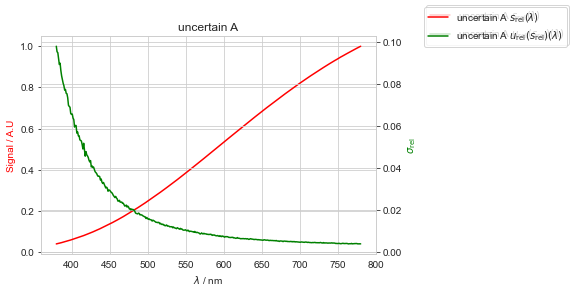

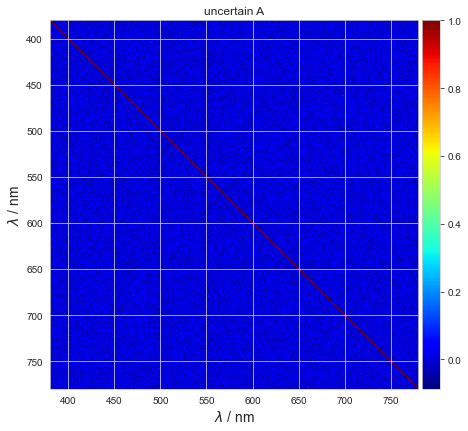

[[2855.6127603895357, 2.600636989794803], [2850.5454801502565, 2860.7685322000816]]


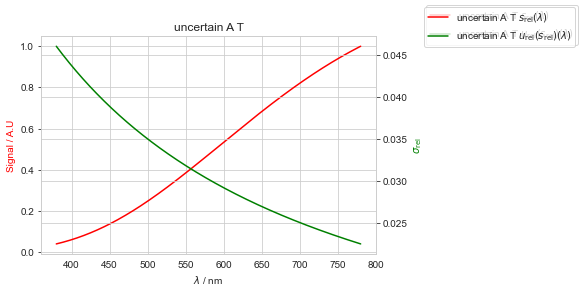

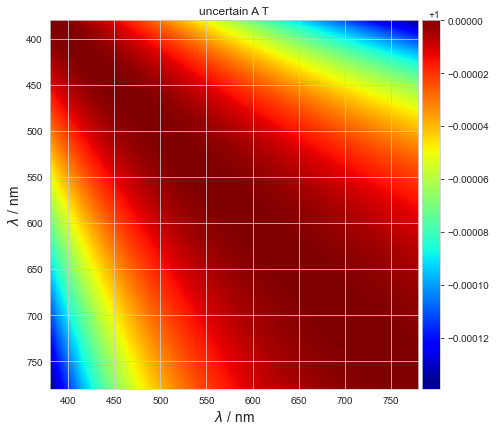

[[2856.004926183344, 9.927528056905288], [2836.851224512622, 2875.1754314573523]]


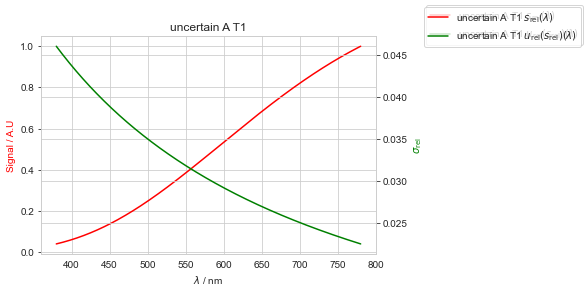

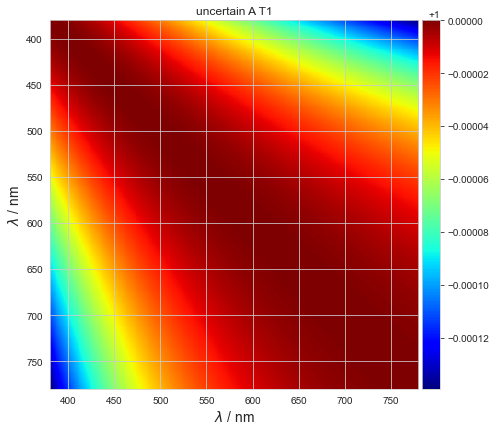

[[2856.004926183344, 9.92752805690518], [2836.85122451262, 2875.1754314573504]]


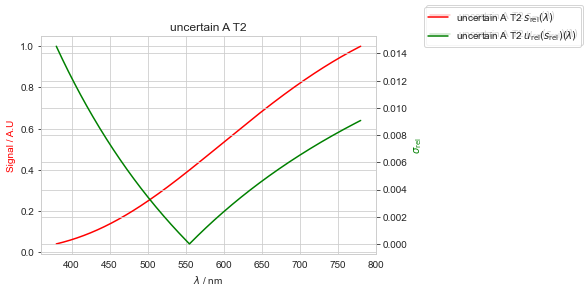

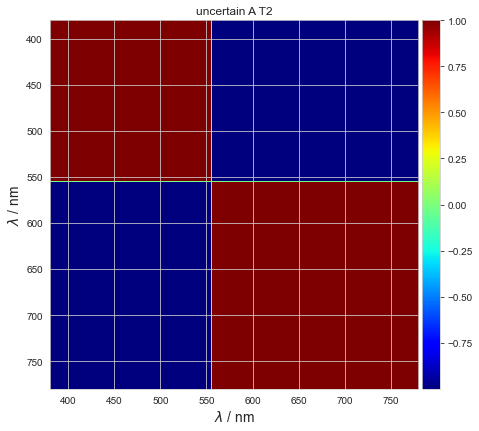

[[2856.004926183344, 9.92752805690523], [2836.851224512621, 2875.1754314573473]]


In [11]:
for mc in [calibrationMC, calibrationMCT, calibrationMCT1, calibrationMCT2]:
    fig, ax1, ax2 = plotMCResult(wl, mc.runData, mc.name.name)
    fig.legend(bbox_to_anchor=(1,1), loc="upper left")
    save_fig(out_dir, mc.name.name + '_SDi')

    plotCorrelation(mc.runData.corr_matrix, wl, mc.name.name)
    save_fig(out_dir, mc.name.name + '_Corri')
    tmpData = np.vstack( (wl, mc.val))
    tmpCCT = lx.xyz_to_cct(lx.spd_to_xyz( tmpData, relative=False, cieobs='1931_2'))
    print( sumMC(tmpCCT))

In [12]:
SMCF_A = lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors( _spectra, _detector, S_C='A', cieobs='1931_2', s_target_index=2)
print( f'SMCF for calibration with standard illuminant A: {SMCF_A[0][0]:.6}')
SMCF_L41 = lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors( _spectra, _detector, S_C='L41', cieobs='1931_2', s_target_index=2)
print( f'SMCF for calibration with standard illuminant L41: {SMCF_L41[0][0]:.6}')

SMCF for calibration with standard illuminant A: 1.00049
SMCF for calibration with standard illuminant L41: 0.984237


# Check the more general SMCF calculation

In [13]:
F, F_C_N, F_C_D, F_M_N, F_M_D = smcf_calculation( _spectra, _detector, S_C='A', cieobs='1931_2', s_target_index=2)
print(f'CIE standard illuminant A: {F}, {F_C_N}, {F_C_D}, {F_M_N}, {F_M_D} --> reduced: {F_M_N/F_M_D}')

F, F_C_N, F_C_D, F_M_N, F_M_D = smcf_calculation( _spectra, _detector, S_C='L41', cieobs='1931_2', s_target_index=2)
print(f'CIE reference source L41: {F}, {F_C_N}, {F_C_D}, {F_M_N}, {F_M_D} --> reduced: {F_M_N/F_M_D}')


CIE standard illuminant A: [[1.0005e+00]], [[1.1313e+04]], [[1.0790e+04]], [[5.0609e+00]], [[5.3039e+00]] --> reduced: [[9.5418e-01]]
CIE reference source L41: [[9.8424e-01]], [[1.5102e+03]], [[1.4641e+03]], [[5.0609e+00]], [[5.3039e+00]] --> reduced: [[9.5418e-01]]


# MCS

In [14]:

def runSimpleMC( calibrationMC, spectraMC, detectorMC, SMCF, calib_cct, NumberTrials, model_single):
    input = [calibrationMC, spectraMC, detectorMC]
    output = [SMCF, calib_cct]

    sim = MCSimulation(trials=NumberTrials)
    sim.set_input_var(input)
    sim.set_output_var(output)
    sim.generate()
    sim.calculate_model( model_single)
    return sim.output_var, sim.get_result_db()

def model_single(calibration, spectra, detector):
    spectmp = np.vstack( (wl, spectra) )
    detectortmp = np.vstack( (wl, detector) )
    calibrationtmp = np.vstack( (wl, calibration))
    cct = lx.xyz_to_cct(lx.spd_to_xyz( calibrationtmp, relative=False, cieobs='1931_2'))[0,0]
#    SMCF_g, F_C_N, F_C_D, F_M_N, F_M_D = smcf_calculation( spectmp, detectortmp, S_C='A', cieobs='1931_2', s_target_index=2, use_ref=False, use_global_ref=False)
    SMCF_g, F_C_N, F_C_D, F_M_N, F_M_D = smcf_calculation( spectmp, detectortmp, S_C=calibrationtmp, cieobs='1931_2', s_target_index=2, use_ref=False, use_global_ref=False)
    #print(f'{SMCF_g[0][0]}, {F_C_N[0][0]}, {F_C_D[0][0]}, {F_M_N[0][0]}, {F_M_D[0][0]} --> reduced: {F_M_N[0][0]/F_M_D[0][0]}')
    SMCF_a = np.zeros(7)
    SMCF_a[0] = SMCF_g[0][0]
    SMCF_a[1] = F_C_N[0][0]
    SMCF_a[2] = F_C_D[0][0]
    SMCF_a[3] = F_M_N[0][0]
    SMCF_a[4] = F_M_D[0][0]
    SMCF_a[5] = F_C_N[0][0] / F_C_D[0][0]
    SMCF_a[6] = F_M_N[0][0] / F_M_D[0][0]
    return [SMCF_a, cct]

In [15]:
def get_name(i:int)->str:
    return mcResult_db['Input'].values[i]

column_str_MC = ['F','F_{\mathrm{C,N}}','F_{\mathrm{C,D}}','F_{\mathrm{M,N}}','F_{\mathrm{M,D}}','F_{\mathrm{C}}','F_{\mathrm{M}}']
def get_item_name(i:int, use_math = True)->str:
    if use_math:
        return '$' + column_str_MC[i] + '$'
    else:
        return column_str_MC[i]

In [24]:
# run the MCS

# define the results (SMCF, the single integrals and the ratios from calibration and measurement)
SMCF_MC = MCVectorVar( name = NameUnit(column_str_MC, ['' for _ in column_str_MC]), elements=len(column_str_MC))
calib_cct = MCVar(name = NameUnit("calib. CCT",'K'))

mcCalibrationList = [calibrationMC, calibrationMCT, calibrationMCT1, calibrationMCT2]
mcResultList = []
mcResult_dbList = []

str_observe = column_str_MC[5]
#str_observe = 'calib. CCT'
index_observe = 0
observed_value = []
observed_uvalue = []

for index, mcCalibrationTmp in enumerate(mcCalibrationList):
    print ( f'Simulation number : {index}')
    mcResult, mcResult_db = runSimpleMC( mcCalibrationTmp, mcVectorVarFEL, mcVarDetector, SMCF_MC, calib_cct, trials, model_single)
    print ( f"{str_observe}: {mcResult_db[str_observe].iloc[index_observe]:.8f} | u({str_observe}): {mcResult_db['u('+str_observe + ')'].iloc[index_observe]:.8f}")
    mcResultList.append(mcResult)
    mcResult_dbList.append(mcResult_db)


Simulation number : 0
F_{\mathrm{C}}: 1.04853985 | u(F_{\mathrm{C}}): 0.00005513
Simulation number : 1
F_{\mathrm{C}}: 1.04853271 | u(F_{\mathrm{C}}): 0.00002780
Simulation number : 2
F_{\mathrm{C}}: 1.04852577 | u(F_{\mathrm{C}}): 0.00002780
Simulation number : 3
F_{\mathrm{C}}: 1.04853806 | u(F_{\mathrm{C}}): 0.00002779


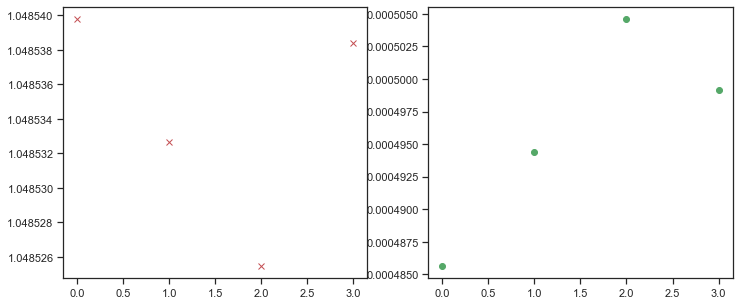

In [25]:
import matplotlib.ticker as ticker

str_observe = column_str_MC[5]
#str_observe = 'calib. CCT'
index_observe = 3
observed_value = []
observed_uvalue = []

for index in range(len(mcCalibrationList)):
    observed_value.append(mcResult_dbList[index][str_observe].iloc[index_observe])
    observed_uvalue.append(mcResult_dbList[index]['u(' + str_observe + ')'].iloc[index_observe])

fig, ax = pyplot.subplots(1, 2, figsize=(12, 5))
formatter = ticker.ScalarFormatter(useOffset=False, useMathText=False)
ax[0].yaxis.set_major_formatter(formatter)
ax[1].yaxis.set_major_formatter(formatter)

ax[0].plot(observed_value, 'rx')
ax[1].plot(observed_uvalue, 'go')

In [26]:
observe = 3
mcResult = mcResultList[observe]
mcResult_db = mcResult_dbList[observe]
mcResult_db

,Input,Unit,Mean,StdDev,Distr,F,u(F),"F_{\mathrm{C,N}}","u(F_{\mathrm{C,N}})","F_{\mathrm{C,D}}",...,"F_{\mathrm{M,N}}","u(F_{\mathrm{M,N}})","F_{\mathrm{M,D}}","u(F_{\mathrm{M,D}})",F_{\mathrm{C}},u(F_{\mathrm{C}}),F_{\mathrm{M}},u(F_{\mathrm{M}}),calib. CCT,u(calib. CCT)
0,uncertain A T2,A.U.,1.22319819,0.01000000,normal,1.00000067,0.00002651,117.30196069,0.09596189,111.87191213,...,5.06115663,0.00000000,5.30421391,0.00000000,1.04853806,0.00002779,0.95417657,0.00000000,"2,856.00492618",9.92752806
0,PTBResFEL-1000W-Lamp-1,A.U.,0.05002378,0.00022769,normal,1.00000002,0.00002669,117.30027995,0.00000000,111.87038675,...,5.06115001,0.02309947,5.30420698,0.02423038,1.04853736,0.00000000,0.95417659,0.00002547,"2,856.10657219",0.00000000
0,Add_PTBResPhot1,A.U.,0.28028599,0.00014701,normal,1.00000000,0.00000240,117.30031628,0.05572503,111.87038675,...,5.06115663,0.00000000,5.30421557,0.00251973,1.04853768,0.00049812,0.95417649,0.00045326,"2,856.10657219",0.00000000
0,All,,,,,1.00000068,0.00003730,117.30199724,0.11143364,111.87191213,...,5.06115001,0.02309947,5.30420859,0.02434947,1.04853839,0.00049916,0.95417650,0.00045364,"2,856.00492618",9.92752806


Value= [0.954176568702476, 4.440892098500626e-16] Inteval(95%)= 0.0 U= 0.0
Value= [0.9541765851927092, 2.5470353359665542e-05] Inteval(95%)= 0.00010179426723588847 U= 5.0897133617944235e-05
Value= [0.9541764863570174, 0.0004532626117858545] Inteval(95%)= 0.00175009229814016 U= 0.00087504614907008


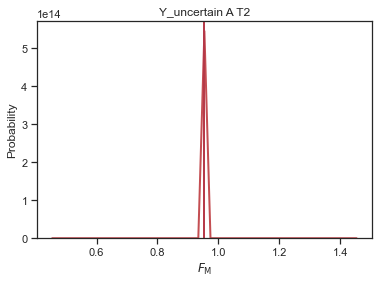

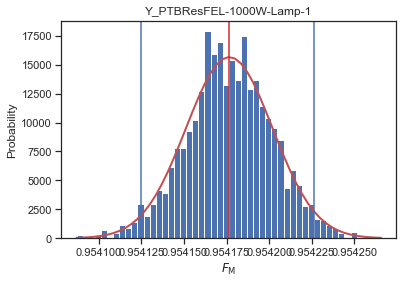

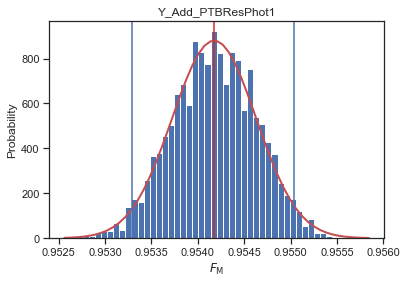

In [27]:
j_observation = 6
for i in range(2+1):
    var = mcResult[i]
    plotHistScales( var[0].val[:,j_observation], add_distribution=True, title='Y_'+get_name(i), xLabel=get_item_name(j_observation))


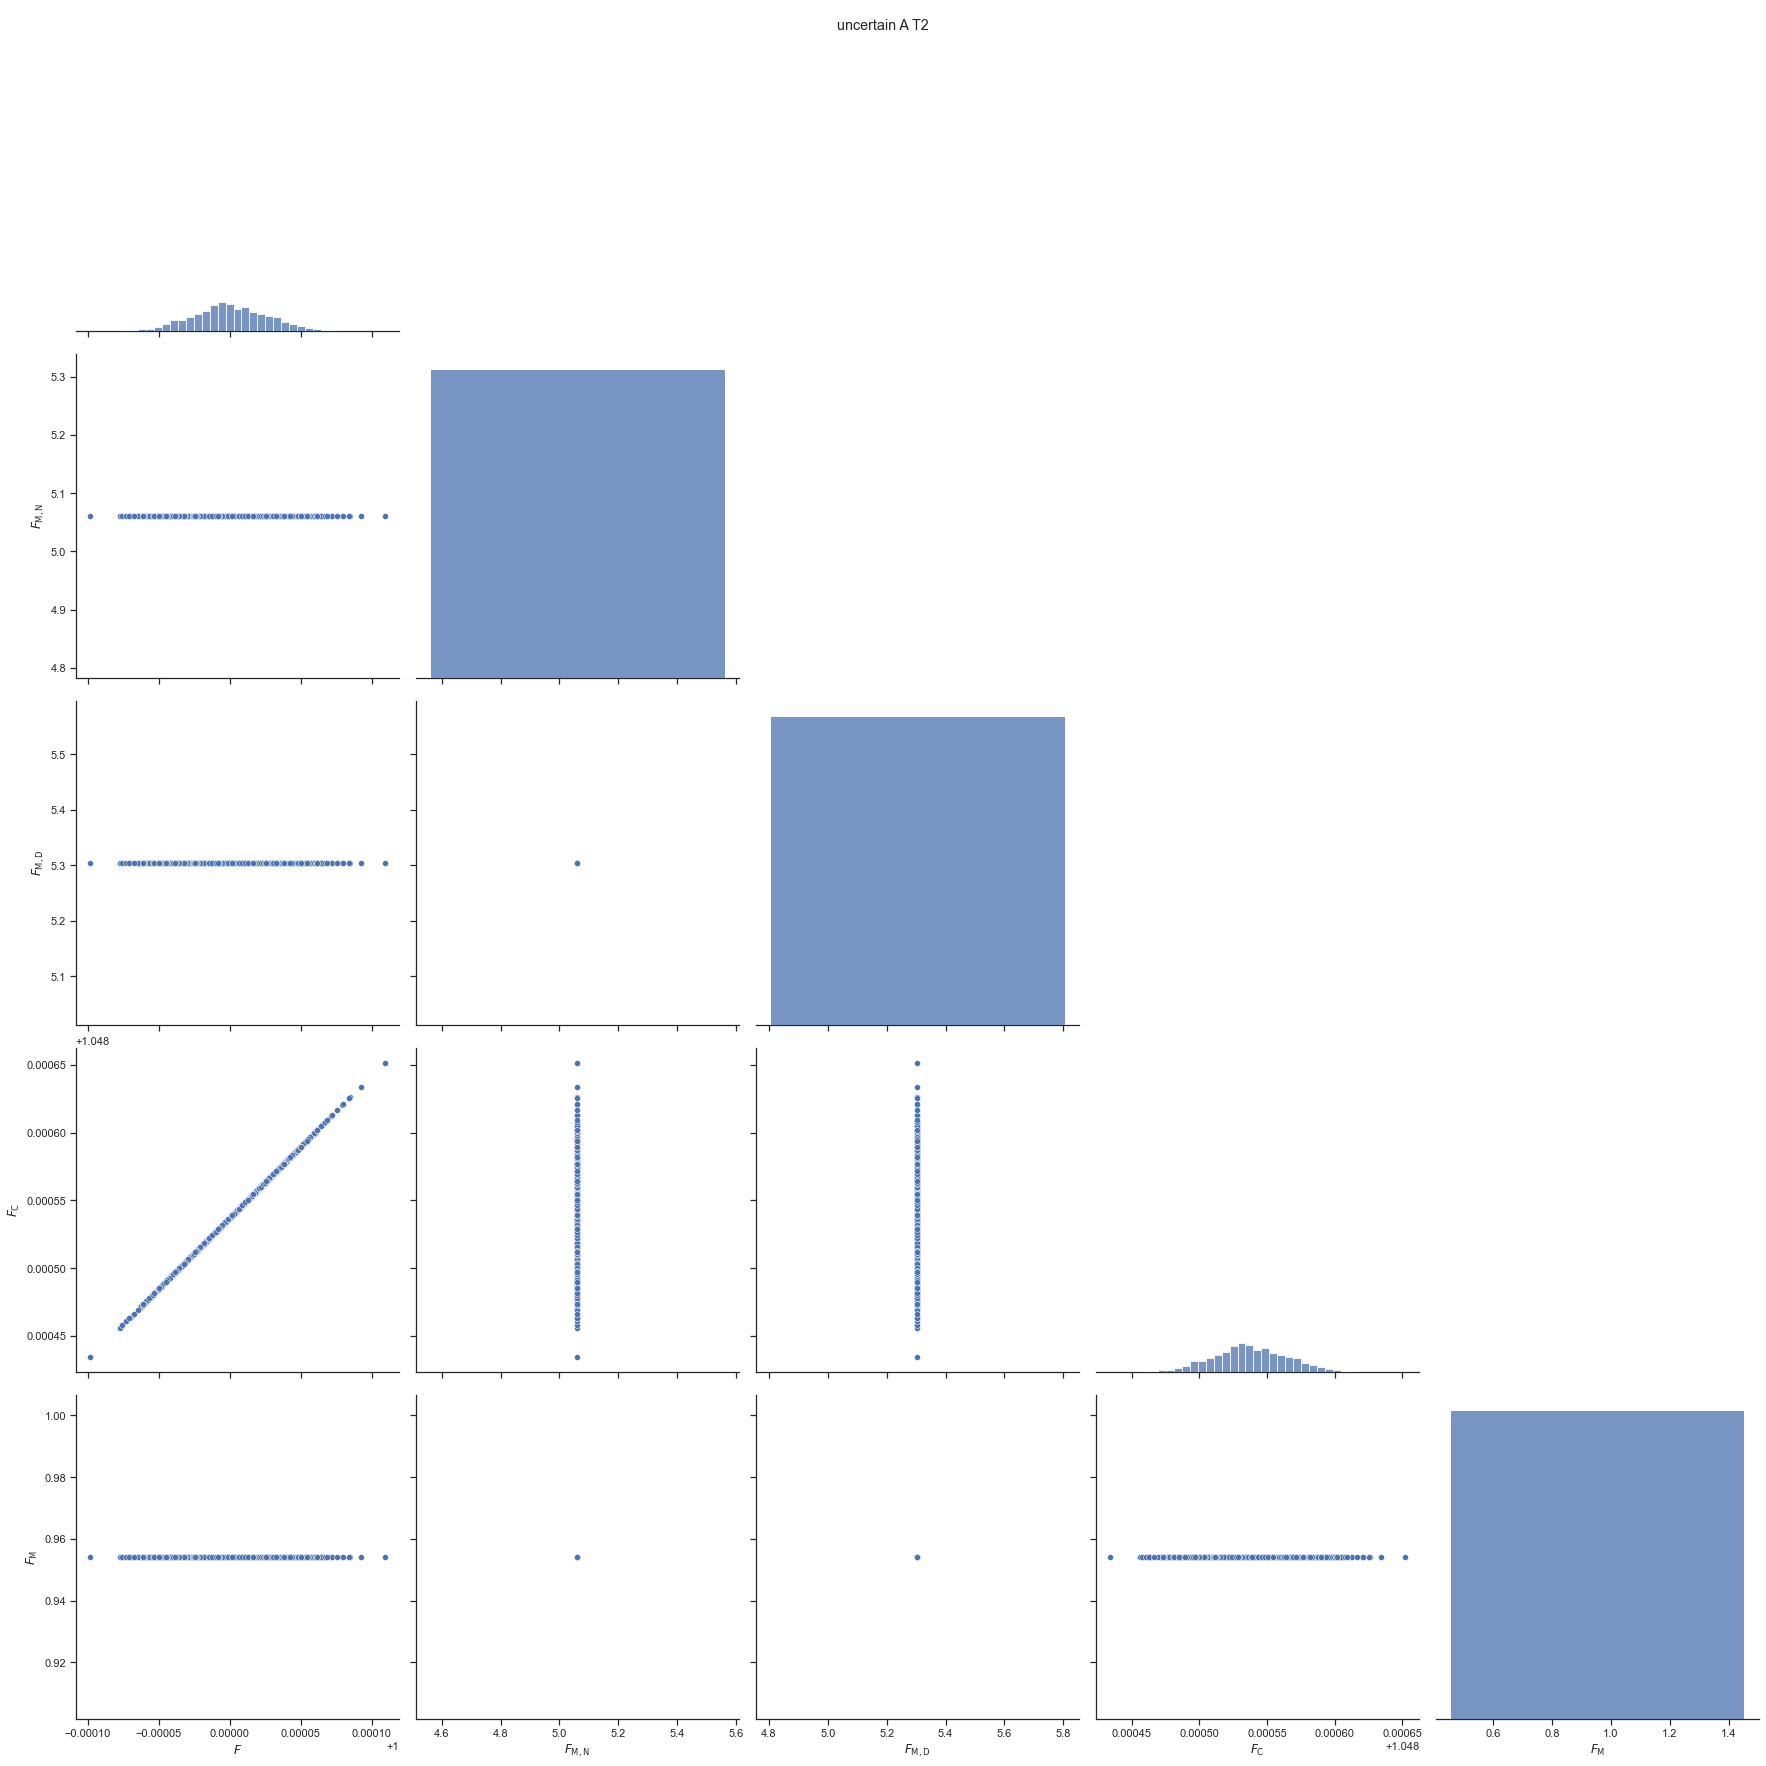

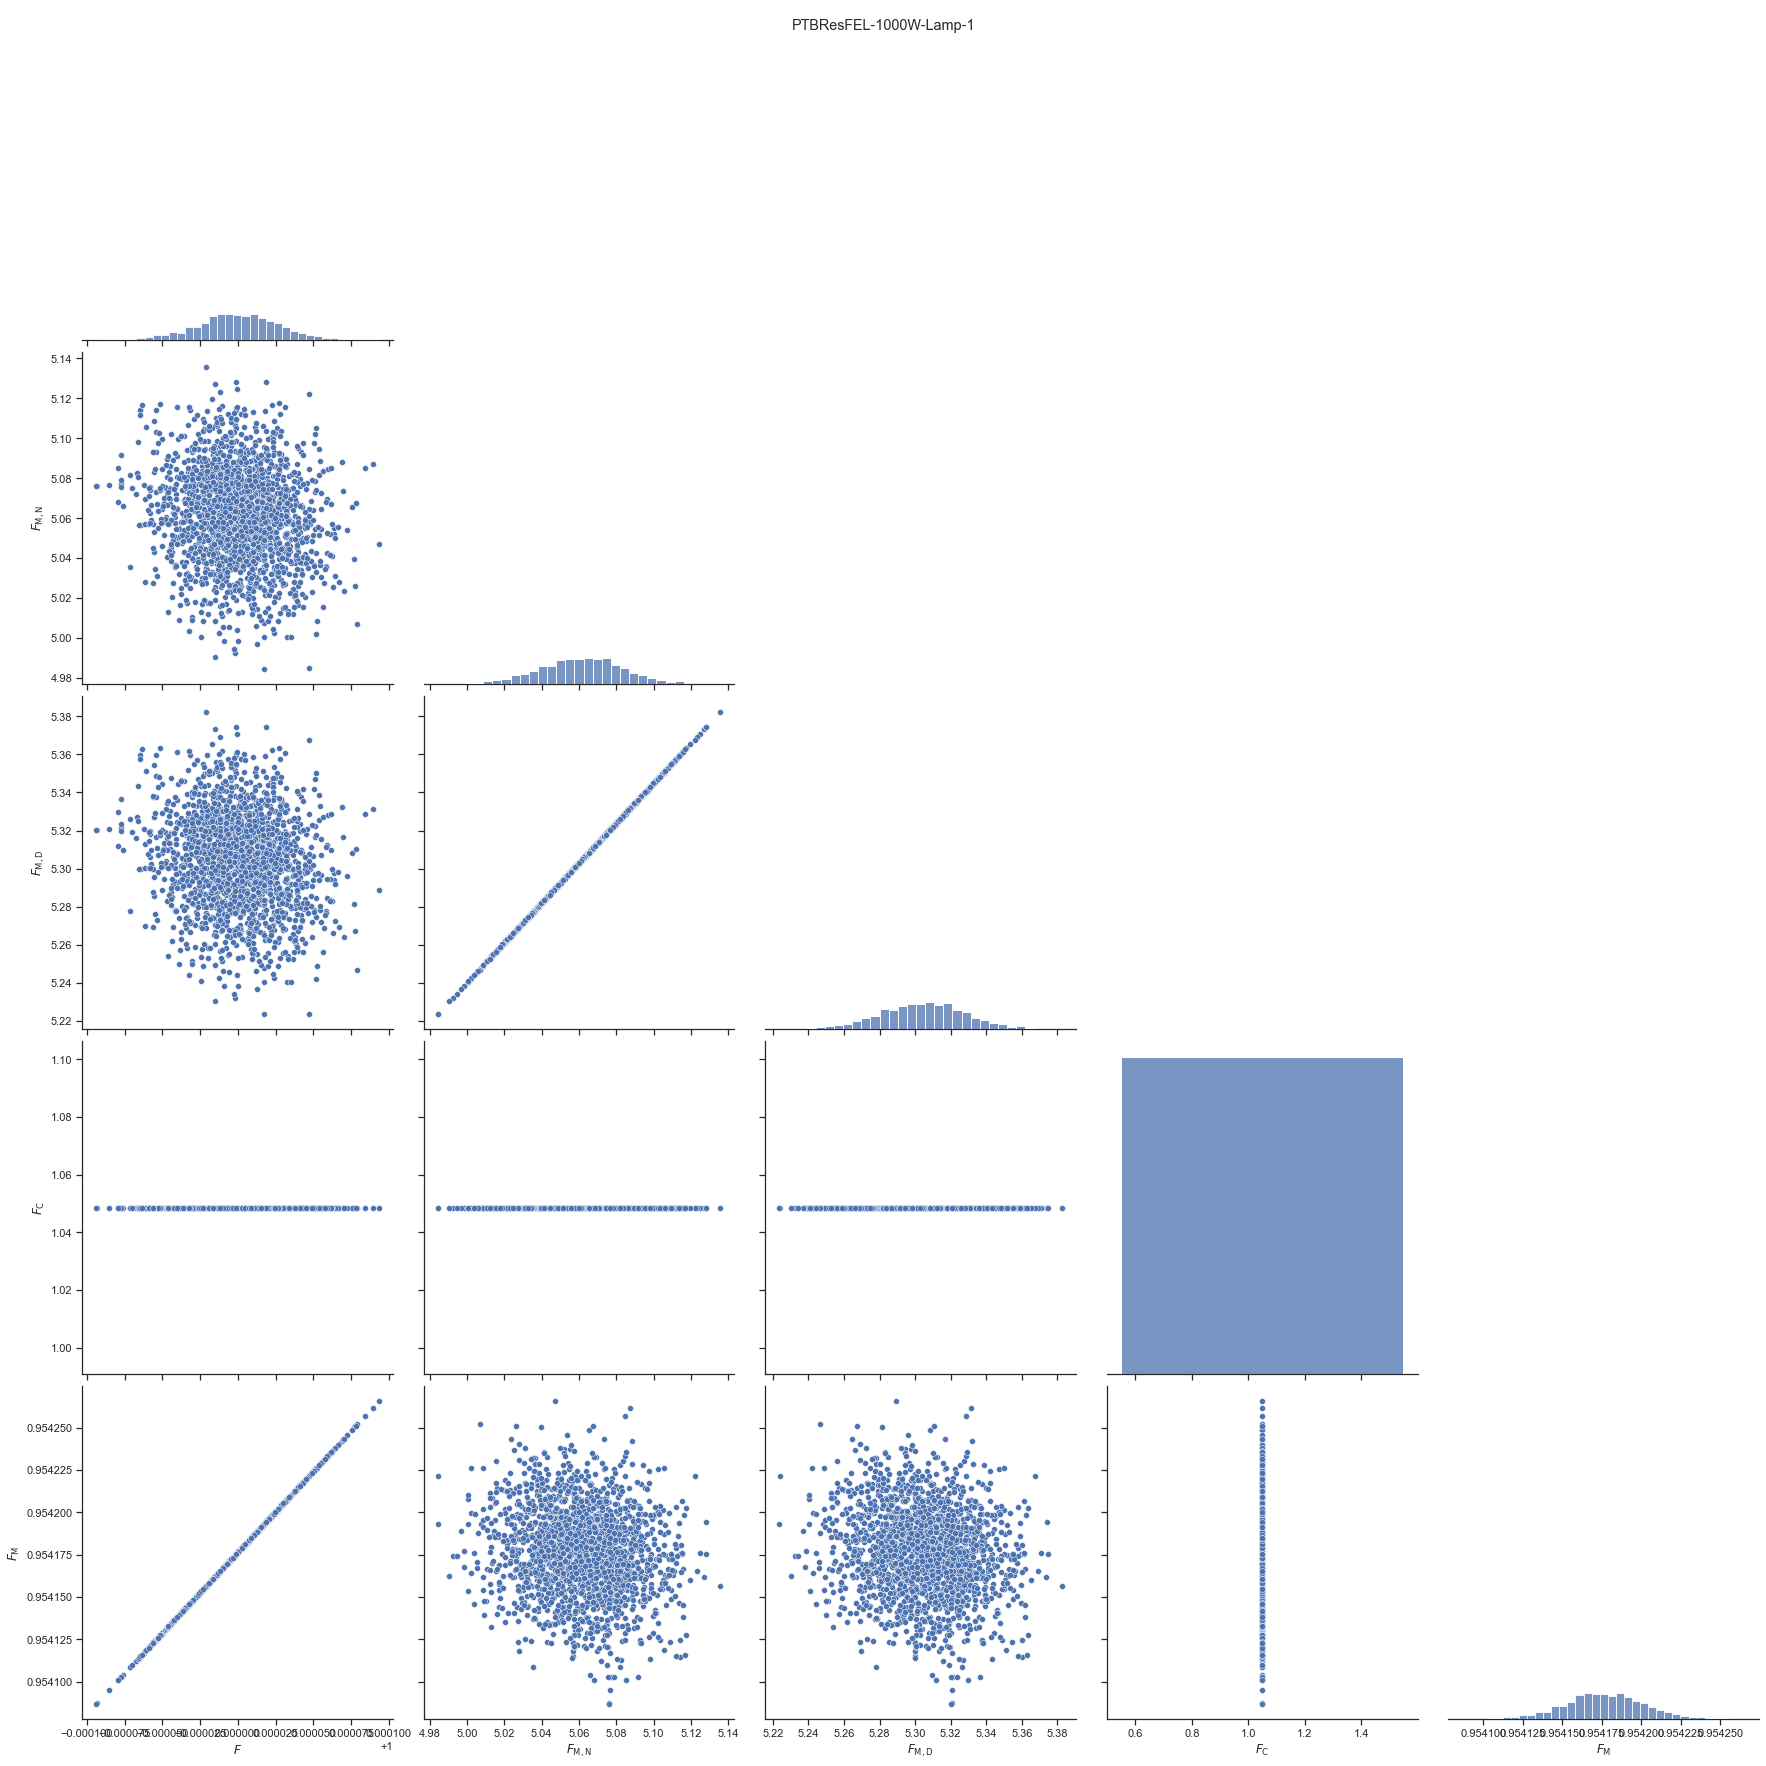

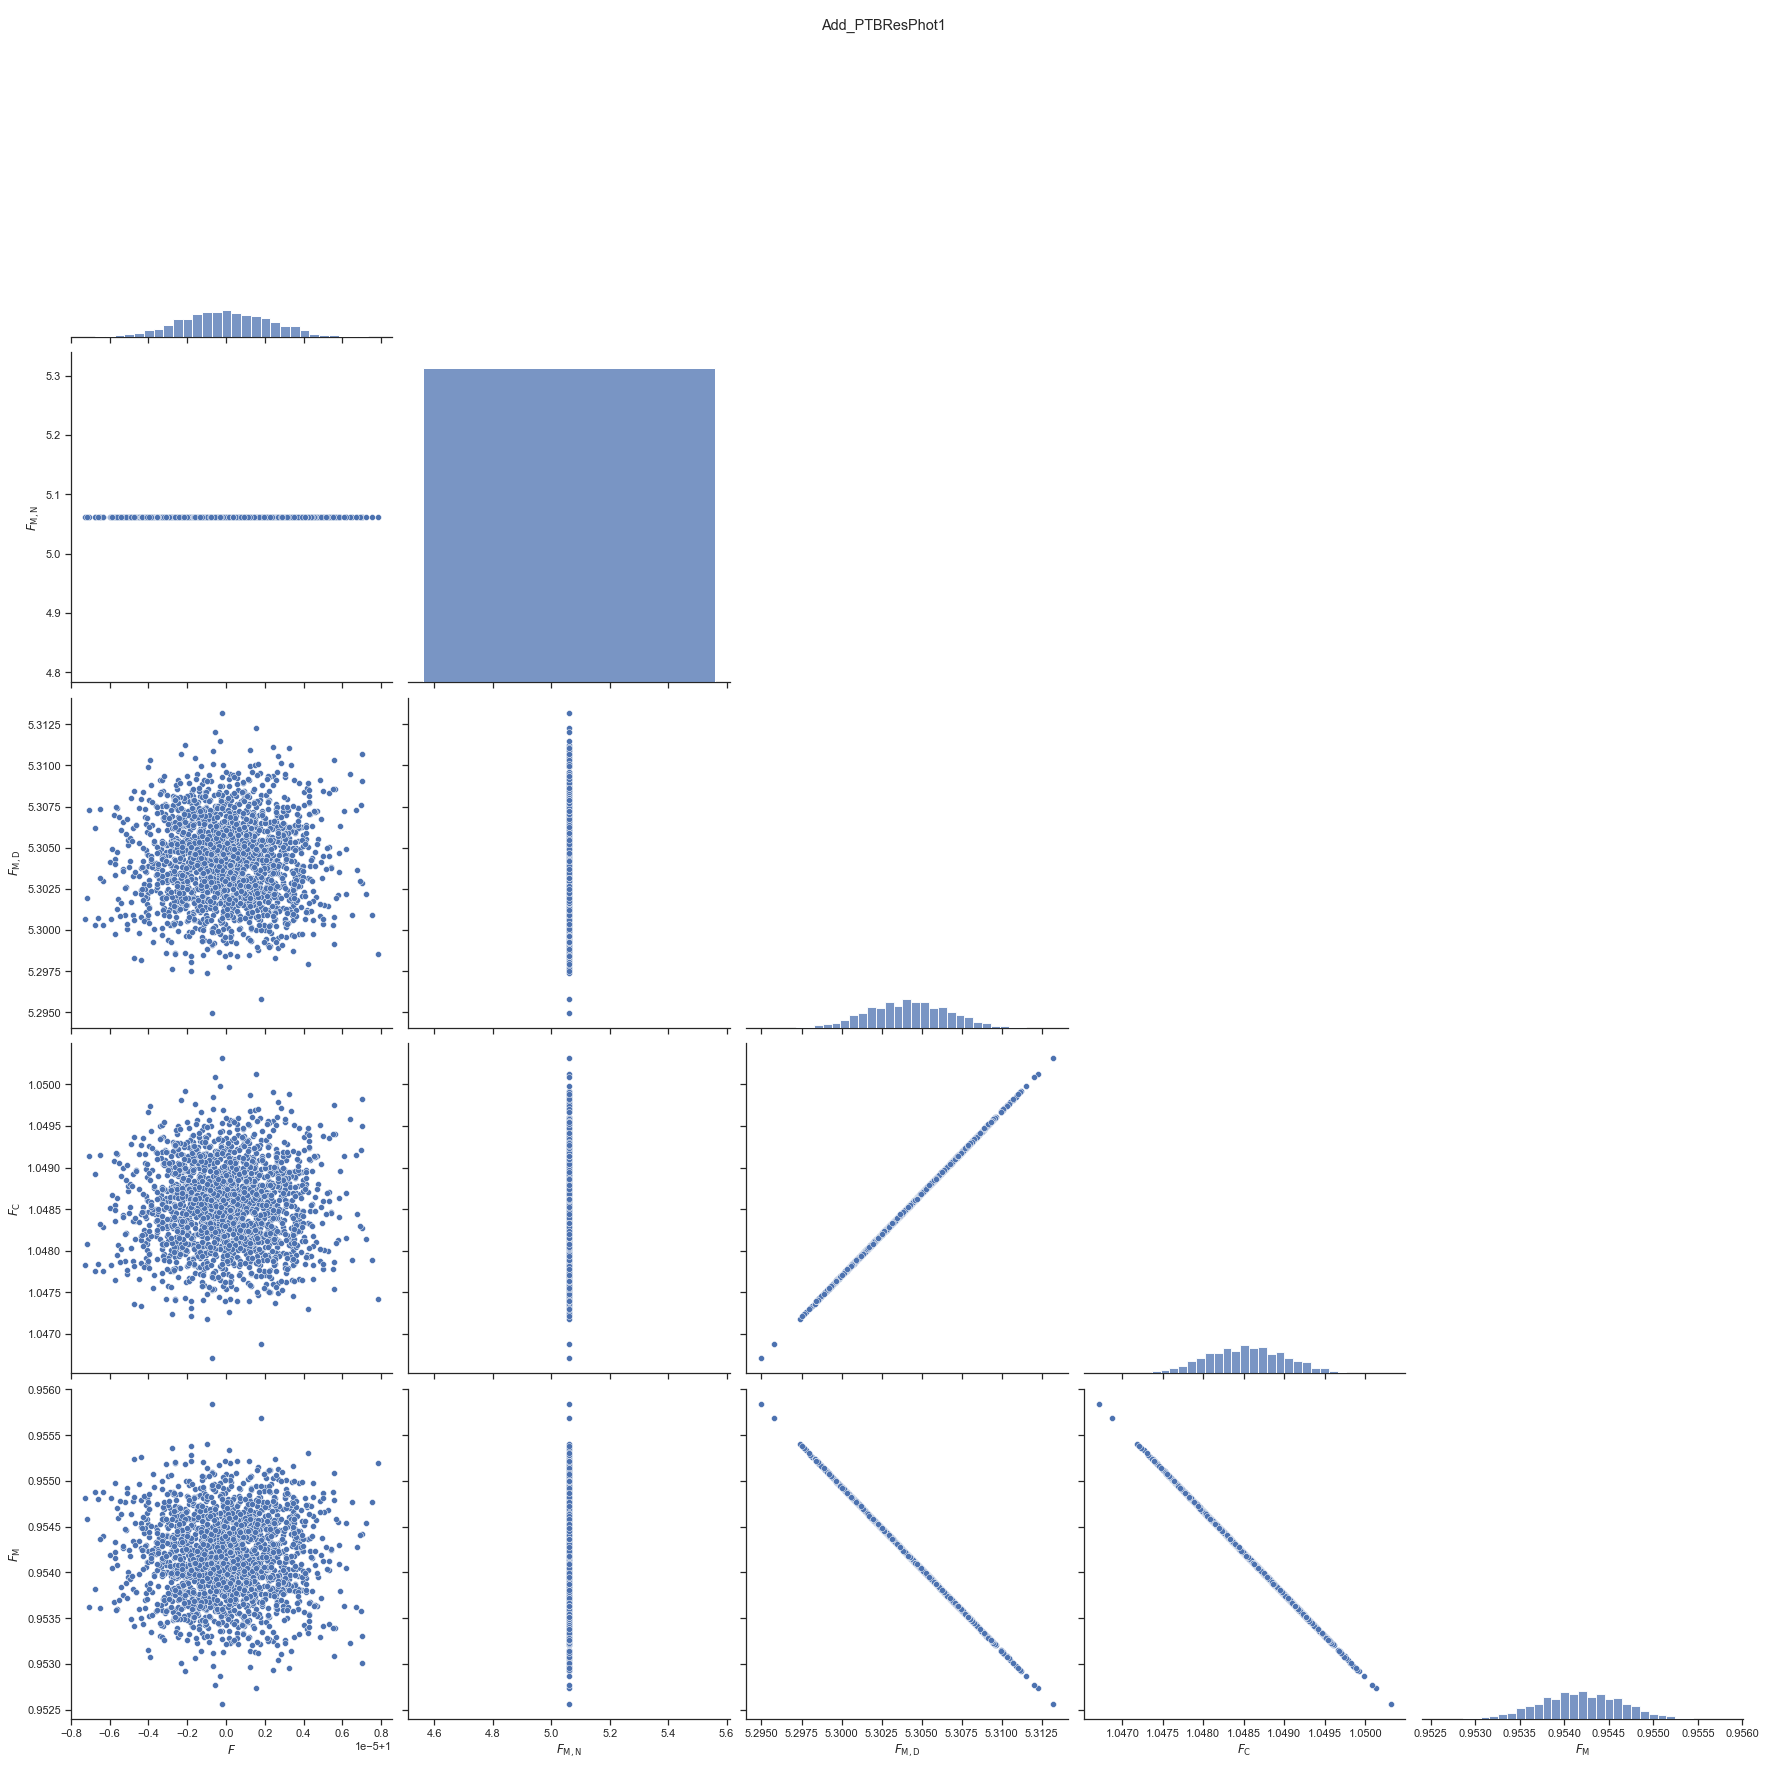

In [28]:
# use selected data only (F, F_C and F_M)
display_list = [0, 3, 4, 5, 6]
for i in range(2+1):
    var = mcResult[i][0].val.T
    seaborn_plot_result_gen(
        np.vstack([var[display_list[_j]] for _j in range(len(display_list))]),
        display=['n' for _ in range(len(display_list))], dim=len(display_list),
        column_str=[get_item_name(display_list[_i], use_math=False) for _i in range(len(display_list))], title=get_name(i))

In [29]:
from empir19nrm02.MC import generate_base_functions
import pandas as pd
from empir19nrm02.tools import sumMC
elements2Run = [0,1,2,3,4,5,6,7,8,9,10,20,30,40,47, 50,60,70,80,90,100,150,200,235]

def FourierTableSMCF( trials, wl, SD, uSD, Detector, uDetector, mode = 'f', single = ' '):
    wl_elements = wl.shape[0]
    print( wl_elements)
    #elements2Run = [10]
    petriTable = pd.DataFrame()
    rMatrixSD = np.zeros((trials, wl.shape[0]))
    detector_tmp = np.vstack((wl, Detector))
    for i, numberNew in enumerate(elements2Run):
        for j in range(trials):
            rMatrix=generate_base_functions( mode + ' ' + str(numberNew) + ' o' + single, wl_elements, uSD)
            rMatrixSD[j] = (1+rMatrix)*SD
        tmp_data =np.vstack(( wl, rMatrixSD))
        SMCF_g, F_C_N, F_C_D, F_M_N, F_M_D = smcf_calculation( tmp_data, detector_tmp, S_C='A', cieobs='1931_2', s_target_index=2, use_ref=False, use_global_ref=False)

        # SMCF
        [SMCFvalues, SMCFinterval] = sumMC(SMCF_g, Coverage=0.95)
        # SMCF_C
        [SMCF_Cvalues, SMCF_Cinterval] = sumMC(F_C_N/F_C_D, Coverage=0.95)
        # SMCF_M
        [SMCF_Mvalues, SMCF_Minterval] = sumMC(F_M_N/F_M_D, Coverage=0.95)
        df = pd.DataFrame( { \
            'N': [numberNew], \
            'SMCF': SMCFvalues[0], 'SMCF_std': SMCFvalues[1], 'SMCF_95%': (SMCFinterval[1]-SMCFinterval[0])/2., \
            'SMCF_C': SMCF_Cvalues[0], 'SMCF_C_std': SMCF_Cvalues[1], 'SMCF_C_95%': (SMCF_Cinterval[1]-SMCF_Cinterval[0])/2., \
            'SMCF_M': SMCF_Mvalues[0], 'SMCF_M_std': SMCF_Mvalues[1], 'SMCF_M_95%': (SMCF_Minterval[1]-SMCF_Minterval[0])/2., \
             } , dtype = 'float')

        petriTable = pd.concat( [petriTable, df])
        print( numberNew, end=' ')
    return petriTable

In [30]:
petriTableSMCF=FourierTableSMCF(trials, wl, mcVectorVarFEL.setData.v_mean, 0.005, mcVarDetector.setData.v_mean, 0.01, mode = 'f', single=' ')
petriTableSMCF.to_excel(out_dir + '/' +  'FourierSMCF_f.xlsx')
petriTableSMCF

401
0 1 2 3 4 5 6 7 8 9 10 20 30 40 47 50 60 70 80 90 100 150 200 235 

,N,SMCF,SMCF_std,SMCF_95%,SMCF_C,SMCF_C_std,SMCF_C_95%,SMCF_M,SMCF_M_std,SMCF_M_95%
0,0.00000000,1.00048991,0.00000000,0.00000000,1.04853579,0.00000000,0.00000000,0.95417812,0.00000000,0.00000000
0,1.00000000,1.00048906,0.00008177,0.00015116,1.04853579,0.00000000,0.00000000,0.95417731,0.00007798,0.00014416
0,2.00000000,1.00048797,0.00015120,0.00029200,1.04853579,0.00000000,0.00000000,0.95417628,0.00014420,0.00027848
0,3.00000000,1.00049189,0.00014825,0.00028457,1.04853579,0.00000000,0.00000000,0.95418001,0.00014139,0.00027140
0,4.00000000,1.00049022,0.00013583,0.00026080,1.04853579,0.00000000,0.00000000,0.95417842,0.00012954,0.00024872
0,5.00000000,1.00049026,0.00012667,0.00024474,1.04853579,0.00000000,0.00000000,0.95417846,0.00012081,0.00023341
0,6.00000000,1.00048631,0.00011518,0.00022326,1.04853579,0.00000000,0.00000000,0.95417468,0.00010985,0.00021293
0,7.00000000,1.00049483,0.00010986,0.00021093,1.04853579,0.00000000,0.00000000,0.95418282,0.00010477,0.00020117
0,8.00000000,1.00049067,0.00010348,0.00020256,1.04853579,0.00000000,0.00000000,0.95417885,0.00009869,0.00019319
0,9.00000000,1.00048947,0.00009984,0.00019623,1.04853579,0.00000000,0.00000000,0.95417771,0.00009522,0.00018715


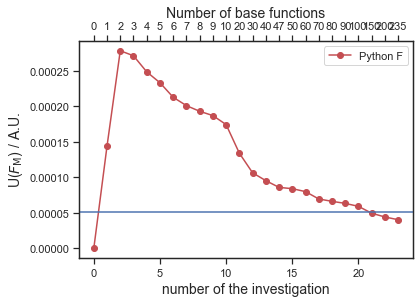

In [31]:
lines =petriTableSMCF.shape[0]
eval=np.zeros((lines, 5))
eval[:,0]=petriTableSMCF["N"].to_numpy().T
eval[:,1]=petriTableSMCF["SMCF_M_95%"].to_numpy().T
xNumber = range(lines)
fig = pyplot.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.set_xlabel(r"number of the investigation",fontsize=label_font_size)
ax1.set_ylabel('U($F_\mathrm{M}$) / A.U.',fontsize=label_font_size)
ax1.plot(xNumber, eval[:,1], 'r-o', label='Python F')
pyplot.axhline(5.1562451138464915e-05)
new_tick_locations = range( lines)
def tick_function(X):
    return ["%d" % elements2Run[z] for z in X]
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"Number of base functions",fontsize=label_font_size)
ax1.legend()
ax1.grid(False)
ax2.grid(False)
save_fig(out_dir, 'SMCF_M_Table1')